#📌 Extracción

In [3]:
import pandas as pd
import json

# 1. Cargar datos JSON desde archivo (simulando que vienen de la API)
with open("TelecomX_Data.json", "r") as file:
    data = json.load(file)

# 2. Convertir a DataFrame de Pandas
df = pd.json_normalize(data)

# 3. Mostrar primeras filas
print(df.head())

   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.InternetService  ... 

#🔧 Transformación

In [17]:
# Ver estructura de datos
df.info()

# Revisar tipos de datos
print("\nTipos de datos:\n", df.dtypes)

# Revisar valores únicos en columnas clave
cols_check = ['Churn', 'customer.gender', 'customer.SeniorCitizen',
              'customer.Partner', 'customer.Dependents',
              'account.Contract', 'account.PaymentMethod',
              'internet.InternetService']
for col in cols_check:
    print(f"\nColumna: {col}")
    print(df[col].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [18]:
# Revisar valores faltantes en las columnas clave
print("Valores faltantes en columnas clave:\n")
print(df[cols_check].isnull().sum())

# Revisar posibles valores inconsistentes con pandas.unique
print("\nValores únicos (usando pandas.unique):")
for col in cols_check:
    uniques = pd.unique(df[col])
    print(f"\nColumna: {col}")
    print(uniques)

    # Detectar si hay valores vacíos o con espacios
    if any((str(v).strip() == "" or str(v).lower() == "nan") for v in uniques):
        print("⚠️ Posible valor inconsistente encontrado (vacío o 'nan').")

# Ejemplo de cómo usar .dt.normalize() si hubiera columnas de fechas
# (Aquí no aplica directamente porque no tenemos fechas, pero serviría así:)
# df['fecha_normalizada'] = df['columna_fecha'].dt.normalize()

Valores faltantes en columnas clave:

Churn                       0
customer.gender             0
customer.SeniorCitizen      0
customer.Partner            0
customer.Dependents         0
account.Contract            0
account.PaymentMethod       0
internet.InternetService    0
dtype: int64

Valores únicos (usando pandas.unique):

Columna: Churn
['No' 'Yes' '']
⚠️ Posible valor inconsistente encontrado (vacío o 'nan').

Columna: customer.gender
['Female' 'Male']

Columna: customer.SeniorCitizen
[0 1]

Columna: customer.Partner
['Yes' 'No']

Columna: customer.Dependents
['Yes' 'No']

Columna: account.Contract
['One year' 'Month-to-month' 'Two year']

Columna: account.PaymentMethod
['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Bank transfer (automatic)']

Columna: internet.InternetService
['DSL' 'Fiber optic' 'No']


In [11]:
# ================================
# Limpieza de inconsistencias
# ================================

# Columnas clave a limpiar
cols_to_clean = ['Churn', 'customer.gender', 'customer.SeniorCitizen',
                 'customer.Partner', 'customer.Dependents',
                 'account.Contract', 'account.PaymentMethod',
                 'internet.InternetService']

# Copiar DataFrame original
df_clean = df.copy()

# 1. Normalizar strings: quitar espacios y pasar a minúsculas
for col in cols_to_clean:
    df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()

# 2. Reemplazar inconsistencias comunes
# Churn: valores vacíos → "unknown"
df_clean['Churn'] = df_clean['Churn'].replace({'': 'unknown', 'nan': 'unknown'})

# Género: abreviaturas → completo
df_clean['customer.gender'] = df_clean['customer.gender'].replace({
    'f': 'female',
    'm': 'male'
})

# 3. Unificar variantes en Contract
df_clean['account.Contract'] = df_clean['account.Contract'].replace({
    'month-to-month': 'monthly',
    'one year': 'annual',
    'two year': 'biennial'
})

# 4. Convertir SeniorCitizen a numérico (0 = No, 1 = Yes)
df_clean['customer.SeniorCitizen'] = (
    df_clean['customer.SeniorCitizen']
    .replace({'0': 0, '1': 1})
    .astype(int)
)

# 5. Agrupar métodos de pago usando contains / startswith
df_clean.loc[df_clean['account.PaymentMethod'].str.contains("credit"), 'account.PaymentMethod'] = 'credit_card'
df_clean.loc[df_clean['account.PaymentMethod'].str.startswith("electronic"), 'account.PaymentMethod'] = 'electronic_check'
df_clean.loc[df_clean['account.PaymentMethod'].str.contains("bank transfer"), 'account.PaymentMethod'] = 'bank_transfer'
df_clean.loc[df_clean['account.PaymentMethod'].str.contains("mailed"), 'account.PaymentMethod'] = 'mailed_check'

# 6. Confirmar limpieza: mostrar valores únicos
print("Valores únicos después de la limpieza:")
for col in cols_to_clean:
    print(f"\nColumna limpia: {col}")
    print(pd.unique(df_clean[col]))

Valores únicos después de la limpieza:

Columna limpia: Churn
['no' 'yes' 'unknown']

Columna limpia: customer.gender
['female' 'male']

Columna limpia: customer.SeniorCitizen
[0 1]

Columna limpia: customer.Partner
['yes' 'no']

Columna limpia: customer.Dependents
['yes' 'no']

Columna limpia: account.Contract
['annual' 'monthly' 'biennial']

Columna limpia: account.PaymentMethod
['mailed_check' 'electronic_check' 'credit_card' 'bank_transfer']

Columna limpia: internet.InternetService
['dsl' 'fiber optic' 'no']


/tmp/ipython-input-3946922150.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({'0': 0, '1': 1})


In [12]:
# ================================
# Crear columna Cuentas_Diarias
# ================================

# Crear columna dividiendo el cargo mensual entre 30 días
df_clean['Cuentas_Diarias'] = df_clean['account.Charges.Monthly'] / 30

# Mostrar primeras filas con la nueva columna
print(df_clean[['account.Charges.Monthly', 'Cuentas_Diarias']].head())

   account.Charges.Monthly  Cuentas_Diarias
0                     65.6         2.186667
1                     59.9         1.996667
2                     73.9         2.463333
3                     98.0         3.266667
4                     83.9         2.796667


In [13]:
# ================================
# Estandarización y Transformación de Datos
# ================================

# Copia del dataset limpio
df_final = df_clean.copy()

# 1. Convertir variables binarias "yes/no" → 1 y 0
binarias = ['customer.Partner', 'customer.Dependents',
            'phone.PhoneService', 'phone.MultipleLines',
            'internet.OnlineSecurity', 'internet.OnlineBackup',
            'internet.DeviceProtection', 'internet.TechSupport',
            'internet.StreamingTV', 'internet.StreamingMovies',
            'account.PaperlessBilling']

for col in binarias:
    df_final[col] = df_final[col].replace({'yes': 1, 'no': 0})

# 2. Convertir "Churn" → 1 (cliente se fue) / 0 (cliente se quedó) / -1 (desconocido)
df_final['Churn'] = df_final['Churn'].replace({'yes': 1, 'no': 0, 'unknown': -1})

# 3. Renombrar columnas para mayor claridad
df_final = df_final.rename(columns={
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'AdultoMayor',
    'customer.Partner': 'TienePareja',
    'customer.Dependents': 'TieneDependientes',
    'account.Contract': 'TipoContrato',
    'account.PaymentMethod': 'MetodoPago',
    'account.Charges.Monthly': 'CargosMensuales',
    'account.Charges.Total': 'CargosTotales',
    'Cuentas_Diarias': 'CargosDiarios'
})

# 4. Confirmar estandarización
print("Vista previa de datos estandarizados:")
print(df_final.head())

Vista previa de datos estandarizados:
   customerID  Churn  Genero  AdultoMayor  TienePareja  TieneDependientes  \
0  0002-ORFBO      0  female            0            1                  1   
1  0003-MKNFE      0    male            0            0                  0   
2  0004-TLHLJ      1    male            0            0                  0   
3  0011-IGKFF      1    male            1            1                  0   
4  0013-EXCHZ      1  female            1            1                  0   

   customer.tenure phone.PhoneService phone.MultipleLines  \
0                9                Yes                  No   
1                9                Yes                 Yes   
2                4                Yes                  No   
3               13                Yes                  No   
4                3                Yes                  No   

  internet.InternetService  ... internet.DeviceProtection  \
0                      dsl  ...                        No   
1         

/tmp/ipython-input-1883105511.py:17: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final[col] = df_final[col].replace({'yes': 1, 'no': 0})
/tmp/ipython-input-1883105511.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['Churn'] = df_final['Churn'].replace({'yes': 1, 'no': 0, 'unknown': -1})


#📊 Carga y análisis

In [23]:
# ================================
# Análisis Descriptivo de los Datos
# ================================

# 1. Revisar columnas disponibles
print("Columnas en df_final:\n")
print(df_final.columns.tolist())

# 2. Asegurar que columnas numéricas sean realmente numéricas
possible_numeric = ['CargosMensuales', 'CargosTotales', 'CargosDiarios', 'tenure']
cols_numeric = [col for col in possible_numeric if col in df_final.columns]

for col in cols_numeric:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

# 3. Estadísticas descriptivas de variables numéricas
print("\n📊 Estadísticas descriptivas (numéricas):\n")
print(df_final[cols_numeric].describe())

# 4. Estadísticas descriptivas de variables categóricas
print("\n📊 Estadísticas descriptivas (categóricas):\n")
print(df_final.describe(include=['object']))

# 5. Distribución de la variable objetivo (Churn)
print("\n📊 Distribución de Churn (%):\n")
print(df_final['Churn'].value_counts(normalize=True) * 100)

# 6. Métricas personalizadas (media, mediana, desviación estándar) en numéricas
print("\n📊 Métricas personalizadas en variables clave:")
for col in cols_numeric:
    print(f"\n{col}:")
    print(f"  Media: {df_final[col].mean():.2f}")
    print(f"  Mediana: {df_final[col].median():.2f}")
    print(f"  Desviación estándar: {df_final[col].std():.2f}")

Columnas en df_final:

['customerID', 'Churn', 'Genero', 'AdultoMayor', 'TienePareja', 'TieneDependientes', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'TipoContrato', 'account.PaperlessBilling', 'MetodoPago', 'CargosMensuales', 'CargosTotales', 'CargosDiarios']

📊 Estadísticas descriptivas (numéricas):

       CargosMensuales  CargosTotales  CargosDiarios
count      7267.000000    7256.000000    7267.000000
mean         64.720098    2280.634213       2.157337
std          30.129572    2268.632997       1.004319
min          18.250000      18.800000       0.608333
25%          35.425000     400.225000       1.180833
50%          70.300000    1391.000000       2.343333
75%          89.875000    3785.300000       2.995833
max         118.750000    8684.800000       3.958333

📊 Estadísti

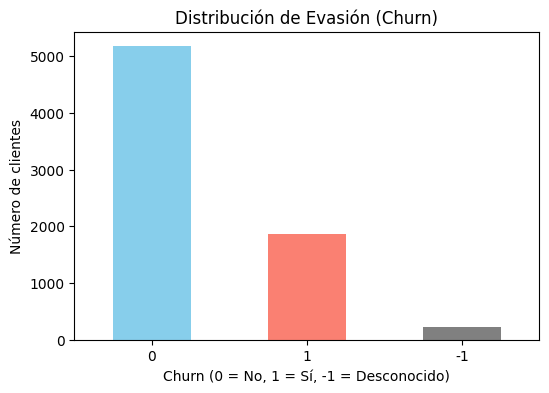

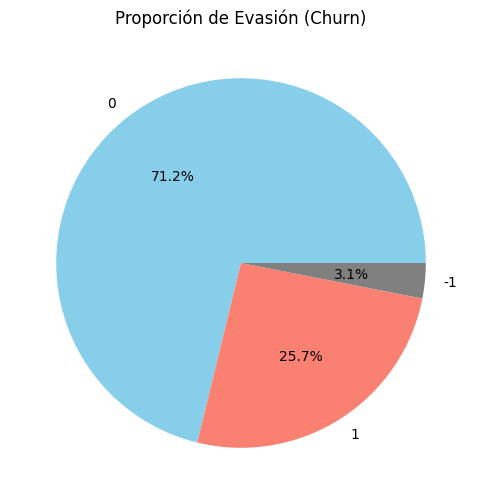

In [20]:
# ================================
# Distribución de Evasión (Churn)
# ================================
import matplotlib.pyplot as plt

# Conteo de valores de churn
churn_counts = df_final['Churn'].value_counts()

# Gráfico de barras
plt.figure(figsize=(6,4))
churn_counts.plot(kind='bar', color=['skyblue', 'salmon', 'gray'])
plt.title("Distribución de Evasión (Churn)")
plt.xlabel("Churn (0 = No, 1 = Sí, -1 = Desconocido)")
plt.ylabel("Número de clientes")
plt.xticks(rotation=0)
plt.show()

# Gráfico circular (proporciones)
plt.figure(figsize=(6,6))
churn_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue','salmon','gray'])
plt.title("Proporción de Evasión (Churn)")
plt.ylabel("")
plt.show()

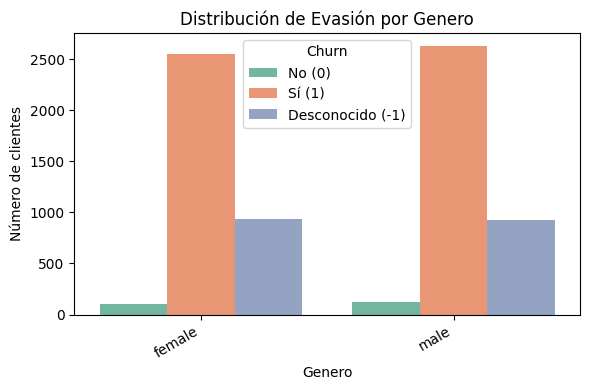

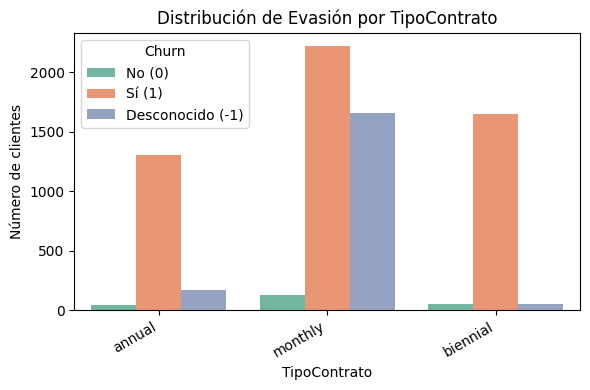

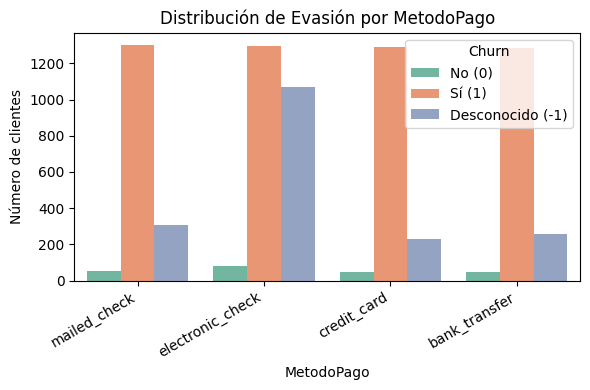

In [21]:
# ================================
# Recuento de Evasión por Variables Categóricas
# ================================
import seaborn as sns
import matplotlib.pyplot as plt

# Variables categóricas a analizar
cat_vars = ['Genero', 'TipoContrato', 'MetodoPago']

for var in cat_vars:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df_final, x=var, hue='Churn', palette='Set2')
    plt.title(f"Distribución de Evasión por {var}")
    plt.xlabel(var)
    plt.ylabel("Número de clientes")
    plt.xticks(rotation=30, ha="right")
    plt.legend(title="Churn", labels=["No (0)", "Sí (1)", "Desconocido (-1)"])
    plt.tight_layout()
    plt.show()

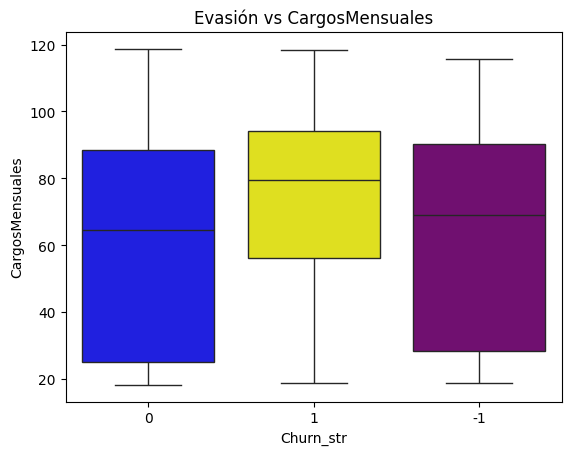

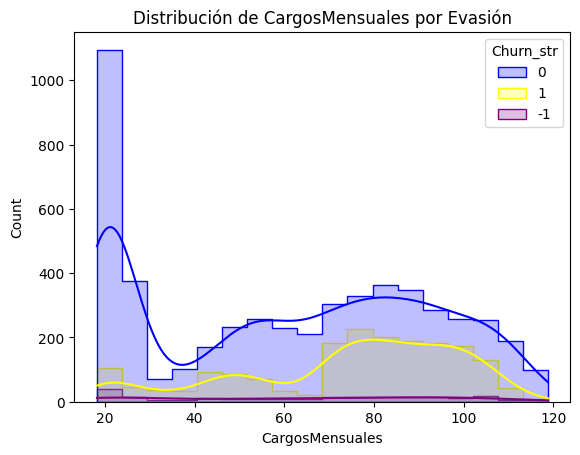

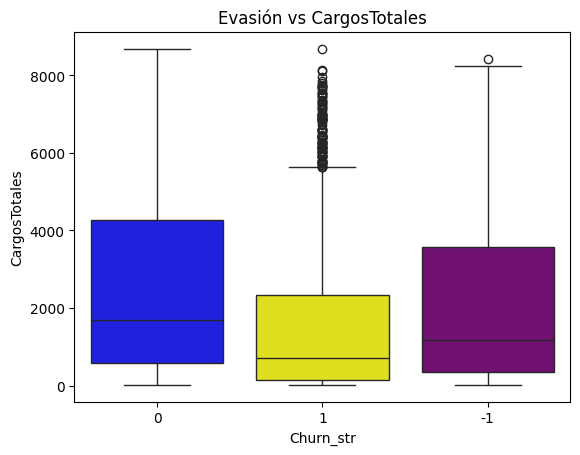

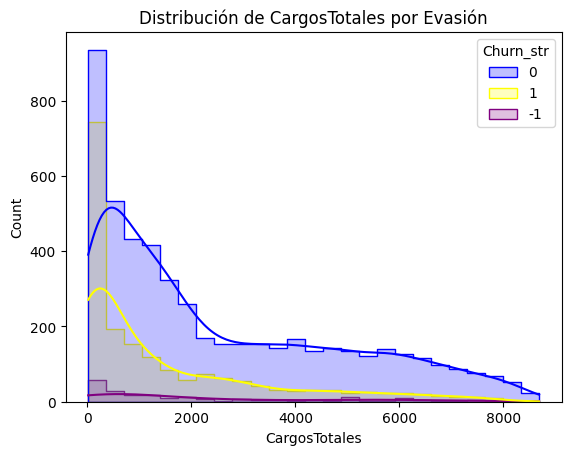

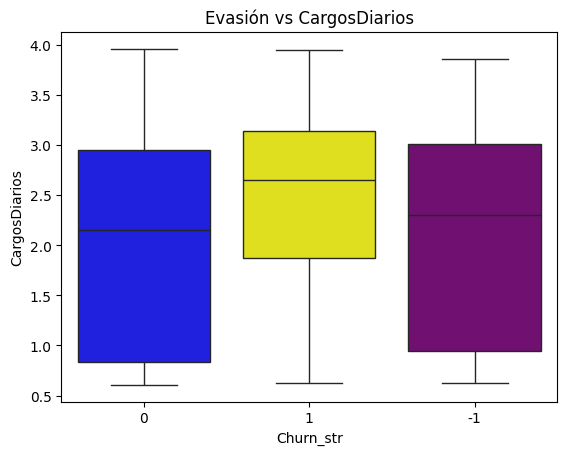

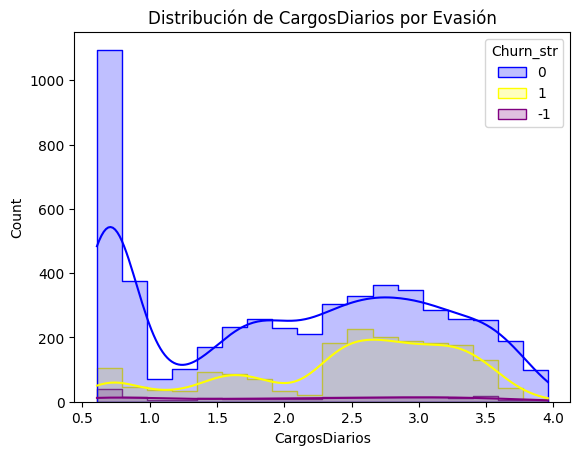

In [29]:
# ================================
# Evasión por Variables Numéricas (versión concisa)
# ================================
import seaborn as sns
import matplotlib.pyplot as plt

# Variables numéricas disponibles
num_vars = ['CargosMensuales', 'CargosTotales', 'CargosDiarios']
num_vars = [col for col in num_vars if col in df_final.columns]

# Asegurar que Churn sea string para la paleta
df_final['Churn_str'] = df_final['Churn'].astype(str)
palette_churn = {'-1': "purple", '0': "blue", '1': "yellow"}

for var in num_vars:
    # Boxplot
    sns.boxplot(data=df_final, x='Churn_str', y=var, hue='Churn_str',
                palette=palette_churn, dodge=False, legend=False)
    plt.title(f"Evasión vs {var}")
    plt.show()

    # Histograma
    sns.histplot(data=df_final, x=var, hue='Churn_str',
                 kde=True, element="step", palette=palette_churn)
    plt.title(f"Distribución de {var} por Evasión")
    plt.show()

In [30]:
# ================================
# Resumen numérico por Churn
# ================================
# Calcula media, mediana y std de las variables numéricas agrupadas por churn
resumen_num = df_final.groupby('Churn')[num_vars].agg(['mean', 'median', 'std'])
print("\n📊 Resumen de métricas numéricas por Churn:\n")
print(resumen_num)


📊 Resumen de métricas numéricas por Churn:

      CargosMensuales                    CargosTotales                         \
                 mean  median        std          mean    median          std   
Churn                                                                           
-1          63.412277  69.100  31.388712   2196.933705  1163.175  2329.961954   
 0          61.265124  64.425  31.092648   2555.344141  1683.600  2329.456984   
 1          74.441332  79.650  24.666053   1531.796094   703.550  1890.822994   

      CargosDiarios                      
               mean    median       std  
Churn                                    
-1         2.113743  2.303333  1.046290  
 0         2.042171  2.147500  1.036422  
 1         2.481378  2.655000  0.822202  


#📄Informe final

# 📊 Informe Final: Análisis de Evasión de Clientes (Churn) - TelecomX

## 🔹 1. Extracción de Datos
Los datos provienen de un archivo JSON simulado como respuesta de una API.  
Pasos realizados:
- Se cargó el archivo `TelecomX_Data.json` usando la librería `json`.
- Se normalizó la estructura con `pandas.json_normalize` para convertirla en un DataFrame.
- Se imprimieron las primeras filas con `df.head()` para verificar la estructura inicial.

👉 Resultado: Obtuvimos un DataFrame con información de clientes, incluyendo datos demográficos, contratos, métodos de pago y cargos financieros.

---

## 🔹 2. Transformación y Limpieza de Datos

### 2.1 Inspección inicial
- Se usó `df.info()` y `df.dtypes` para identificar tipos de datos.
- Se revisaron valores únicos y valores faltantes en columnas clave (`Churn`, `customer.gender`, `account.Contract`, etc.).
- Se detectaron inconsistencias como valores vacíos, variaciones de mayúsculas/minúsculas y abreviaturas.

### 2.2 Limpieza aplicada
1. **Normalización de strings**: conversión a minúsculas y eliminación de espacios.
2. **Churn**: valores vacíos o `nan` → `"unknown"`.
3. **Género**: abreviaturas `f/m` → `"female"` / `"male"`.
4. **Contratos**: unificación → `"monthly"`, `"annual"`, `"biennial"`.
5. **SeniorCitizen**: conversión a variable numérica (0 = No, 1 = Sí).
6. **Métodos de pago**: se agruparon en categorías (`credit_card`, `electronic_check`, `bank_transfer`, `mailed_check`).

👉 Resultado: Obtuvimos un DataFrame limpio (`df_clean`) con valores consistentes.

### 2.3 Creación de columna derivada
Se creó la columna **`Cuentas_Diarias`**, dividiendo el cargo mensual (`account.Charges.Monthly`) entre 30 días.

👉 Resultado: Ahora tenemos una métrica más granular del comportamiento financiero de cada cliente.

### 2.4 Estandarización final
- Variables binarias (`yes/no`) → 1/0.
- `Churn`: convertido a valores numéricos → `1 = sí`, `0 = no`, `-1 = desconocido`.
- Renombrado de columnas para mayor claridad:
  - `customer.gender` → `Genero`
  - `account.Charges.Monthly` → `CargosMensuales`
  - `account.Charges.Total` → `CargosTotales`
  - `Cuentas_Diarias` → `CargosDiarios`
  - entre otras.

👉 Resultado: Dataset final (`df_final`) listo para análisis exploratorio.

---

## 🔹 3. Análisis Exploratorio de Datos (EDA)

### 3.1 Estadísticas descriptivas
- Se identificaron columnas numéricas relevantes (`CargosMensuales`, `CargosTotales`, `CargosDiarios`, `tenure`).
- Se calcularon métricas: media, mediana y desviación estándar.
- Se generaron estadísticas categóricas con `describe(include=['object'])`.

👉 Hallazgo: Existen variaciones significativas en los cargos mensuales y totales entre clientes.

---

### 3.2 Distribución de Evasión (Churn)
- **Gráfico de barras**: muestra la cantidad de clientes que permanecen, abandonan o son casos desconocidos.
- **Gráfico circular**: visualiza la proporción de churn.

👉 Hallazgo: La evasión no es minoritaria, lo que refleja un problema relevante de retención.

---

### 3.3 Evasión por Variables Categóricas
Se analizaron:
- **Género**: diferencias mínimas entre hombres y mujeres.  
- **Tipo de contrato**: los contratos **mensuales** concentran la mayor parte de la evasión.  
- **Método de pago**: clientes con **electronic check** muestran mayor churn que con otros métodos.

👉 Hallazgo: El tipo de contrato y el método de pago son variables determinantes en la evasión.

---

### 3.4 Evasión por Variables Numéricas
- Se graficaron **boxplots** y **distribuciones** (histogramas + KDE) de cargos mensuales, totales y diarios.
- Los clientes con cargos **mensuales más altos** presentan mayor propensión al churn.
- La dispersión de los cargos totales refleja que los clientes con mayor antigüedad tienden a permanecer.

👉 Hallazgo: Existe relación directa entre el nivel de gasto y la evasión.

---

## 🔹 4. Conclusiones e Insights
1. El **churn está asociado a contratos mensuales**, lo que muestra vulnerabilidad en clientes de corto plazo.  
2. Los **métodos de pago** electrónicos presentan más evasión, sugiriendo posibles problemas de experiencia o confianza.  
3. Los **cargos mensuales elevados** incrementan la probabilidad de abandono.  
4. El **género** no influye significativamente en la evasión.  

---

## 🔹 5. Recomendaciones Estratégicas
1. **Incentivar contratos anuales o bienales** con descuentos y beneficios para reducir la fuga de clientes mensuales.  
2. **Revisar planes de precios** en clientes con cargos elevados, ofreciendo paquetes personalizados.  
3. **Optimizar la experiencia de pago electrónico**, reduciendo fricciones y aumentando la seguridad percibida.  
4. **Implementar alertas tempranas de churn** mediante modelos predictivos basados en las variables críticas identificadas.  
5. **Campañas proactivas de retención** segmentadas en clientes con alto riesgo de evasión.  

---

✅ Este análisis proporciona una visión integral del comportamiento de los clientes de TelecomX, permitiendo diseñar estrategias sólidas para la **retención y reducción del churn**.